<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Curvas-horarias" data-toc-modified-id="Curvas-horarias-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Curvas horarias</a></span><ul class="toc-item"><li><span><a href="#Cargar-dato-de-contador" data-toc-modified-id="Cargar-dato-de-contador-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar dato de contador</a></span></li><li><span><a href="#Carga-datos-climatológicos" data-toc-modified-id="Carga-datos-climatológicos-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Carga datos climatológicos</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Daily-merged-df" data-toc-modified-id="Daily-merged-df-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Daily merged df</a></span></li></ul></li></ul></div>

# Curvas horarias

## Cargar dato de contador

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
FIXED_COST = 0.044027
KWH_PRICE = 0.139 + FIXED_COST
KWH_PRICE

0.183027

In [3]:
LOW_COST = 0.082 + FIXED_COST
HIGH_COST = 0.161 + FIXED_COST
LOW_COST, HIGH_COST

(0.126027, 0.20502700000000001)

In [4]:
os.listdir()

['energy_analytics.ipynb',
 'infoenergy (3).csv',
 'diario_aemet_sevilla.json',
 'infoenergy (1).csv',
 'curvas_horarias.ipynb',
 'energy_analytics (3).html',
 'energy_analytics.html',
 'aemet_metadatos.json',
 'infoenergy (4).csv',
 'temp.csv',
 'infoenergy.csv',
 'infoenergy (2).csv',
 '02_regresion.ipynb',
 '02_energy_analytics_plain.ipynb',
 '.ipynb_checkpoints']

In [5]:
energy_csv_filenames = [val for val in os.listdir() if val.startswith('infoenergy')]
energy_csv_filenames

['infoenergy (3).csv',
 'infoenergy (1).csv',
 'infoenergy (4).csv',
 'infoenergy.csv',
 'infoenergy (2).csv']

In [6]:
!head -n 5 infoenergy.csv

date;value
2019/02/05 01:00:00;1968
2019/02/05 02:00:00;1959
2019/02/05 03:00:00;1960
2019/02/05 04:00:00;1978


In [7]:
from tqdm import tqdm


# LOAD AND CONCAT
df_list = []

for filename in tqdm(energy_csv_filenames):
    temp_df = pd.read_csv(filename, sep=';')
    df_list.append(temp_df)    
    
df = pd.concat(df_list)

# TYPE THE DATA
df.date = pd.to_datetime(df.date, format="%Y/%m/%d %H:%M:%S")
df.value = df.value.astype('float')

# CHANGE COLUMNS
df.rename(columns={'value': 'kwh'}, inplace=True)
df.kwh = df.kwh.div(1000)

# SORT BY DATE
df.sort_values('date', ascending=True, inplace=True)

100%|██████████| 5/5 [00:00<00:00, 222.37it/s]


In [8]:
pd.to_datetime('2019-09').year

2019

In [9]:
pd.date_range(start='2019-03-21', periods=4, freq='90D')

DatetimeIndex(['2019-03-21', '2019-06-19', '2019-09-17', '2019-12-16'], dtype='datetime64[ns]', freq='90D')

In [10]:
def get_year_season(date):
    
    year = date.year
    
    spring_begin_date = pd.to_datetime(str(year) + '-03-21')    
    
    break_date_series = pd.Series([spring_begin_date + pd.DateOffset(months=(3 * d)) 
                                   for d in np.arange(0, 4)], 
                                  index=['spring', 'summer', 'autumn', 'winter'])
   
    aux_series = break_date_series.le(date)
    if aux_series.sum() == 0:
        season = 'winter'
    else:
        season = aux_series[aux_series == True].index[-1]      
        
    return season
    
get_year_season(pd.to_datetime('2019-04-21'))    

'spring'

In [11]:
def get_season_from_date_series(date_series):
    
    month_series = date_series.dt.month
    day_number_modifier_series = date_series.dt.day.ge(21).mul(0.5)
    date_repr_series = month_series.add(day_number_modifier_series)
    
    season_series = pd.cut(date_repr_series, 
                           bins=[3.1, 6.1, 9.1, 12.1], 
                           labels=['spring', 'summer', 'autumn']).astype('object')
    season_series.fillna('winter', inplace=True)
    
    return season_series

In [12]:
def get_last_sunday_of_month(year_month):
    """ year_month must be %Y-%m """
    time_stamp = pd.to_datetime(year_month)
    date_range = pd.date_range(start=time_stamp, 
                               periods=31).to_series()
    date_range = date_range[date_range.dt.month.eq(time_stamp.month)]
    dow_series = date_range.dt.weekday_name.copy()
    
    dow_series.drop_duplicates(keep='last', inplace=True)
    val_date_index = dow_series.loc[dow_series.eq('Sunday')].index[0]
    
    return date_range.loc[val_date_index]
    
get_last_sunday_of_month('2019-05')

Timestamp('2019-05-26 00:00:00')

In [13]:
def get_feat_eng(df):
    feat_eng_df = df.copy()
    feat_eng_df.insert( 1, 'daily_date', feat_eng_df.date.dt.to_period('D'))
    feat_eng_df['dow'] = feat_eng_df.date.dt.weekday_name
    feat_eng_df['is_weekend'] = feat_eng_df.dow.isin(['Saturday', 'Sunday'])
    feat_eng_df['hour'] = feat_eng_df.date.dt.hour
    feat_eng_df['is_working_time'] = feat_eng_df.hour.between(9, 19, inclusive=True)
    feat_eng_df['is_night_time'] = feat_eng_df.hour.between(0, 8, inclusive=True)
    feat_eng_df['season'] = get_season_from_date_series(feat_eng_df.date)
    feat_eng_df['cost'] = feat_eng_df.kwh.mul(KWH_PRICE)
    feat_eng_df['discriminative_cost'] = (feat_eng_df.kwh.mul(feat_eng_df.hour.between(12, 22))
                                                         .mul(HIGH_COST)
                                                         .add(
                                          feat_eng_df.kwh.mul(~feat_eng_df.hour.between(12, 22)).mul(LOW_COST)))
    
    return feat_eng_df

In [14]:
df = get_feat_eng(df)
df.head()

,date,daily_date,kwh,dow,is_weekend,hour,is_working_time,is_night_time,season,cost,discriminative_cost
0,2019-02-05 01:00:00,2019-02-05,1.968,Tuesday,False,1,False,True,winter,0.360197,0.248021
1,2019-02-05 02:00:00,2019-02-05,1.959,Tuesday,False,2,False,True,winter,0.358550,0.246887
2,2019-02-05 03:00:00,2019-02-05,1.960,Tuesday,False,3,False,True,winter,0.358733,0.247013
3,2019-02-05 04:00:00,2019-02-05,1.978,Tuesday,False,4,False,True,winter,0.362027,0.249281
4,2019-02-05 05:00:00,2019-02-05,1.892,Tuesday,False,5,False,True,winter,0.346287,0.238443


In [15]:
df.shape

(2903, 11)

In [16]:
df.season.value_counts()

spring    1848
winter    1055
Name: season, dtype: int64

In [17]:
df.tail()

,date,daily_date,kwh,dow,is_weekend,hour,is_working_time,is_night_time,season,cost,discriminative_cost
116,2019-06-05 20:00:00,2019-06-05,0.168,Wednesday,False,20,False,False,spring,0.030749,0.034445
117,2019-06-05 21:00:00,2019-06-05,0.154,Wednesday,False,21,False,False,spring,0.028186,0.031574
118,2019-06-05 22:00:00,2019-06-05,0.229,Wednesday,False,22,False,False,spring,0.041913,0.046951
119,2019-06-05 23:00:00,2019-06-05,0.265,Wednesday,False,23,False,False,spring,0.048502,0.033397
120,2019-06-06 00:00:00,2019-06-06,0.281,Thursday,False,0,False,True,spring,0.051431,0.035414


In [18]:
df.tail()

,date,daily_date,kwh,dow,is_weekend,hour,is_working_time,is_night_time,season,cost,discriminative_cost
116,2019-06-05 20:00:00,2019-06-05,0.168,Wednesday,False,20,False,False,spring,0.030749,0.034445
117,2019-06-05 21:00:00,2019-06-05,0.154,Wednesday,False,21,False,False,spring,0.028186,0.031574
118,2019-06-05 22:00:00,2019-06-05,0.229,Wednesday,False,22,False,False,spring,0.041913,0.046951
119,2019-06-05 23:00:00,2019-06-05,0.265,Wednesday,False,23,False,False,spring,0.048502,0.033397
120,2019-06-06 00:00:00,2019-06-06,0.281,Thursday,False,0,False,True,spring,0.051431,0.035414


In [19]:
df.shape

(2903, 11)

In [20]:
df.dtypes

date                   datetime64[ns]
daily_date                  period[D]
kwh                           float64
dow                            object
is_weekend                       bool
hour                            int64
is_working_time                  bool
is_night_time                    bool
season                         object
cost                          float64
discriminative_cost           float64
dtype: object

In [21]:
df.head()

,date,daily_date,kwh,dow,is_weekend,hour,is_working_time,is_night_time,season,cost,discriminative_cost
0,2019-02-05 01:00:00,2019-02-05,1.968,Tuesday,False,1,False,True,winter,0.360197,0.248021
1,2019-02-05 02:00:00,2019-02-05,1.959,Tuesday,False,2,False,True,winter,0.358550,0.246887
2,2019-02-05 03:00:00,2019-02-05,1.960,Tuesday,False,3,False,True,winter,0.358733,0.247013
3,2019-02-05 04:00:00,2019-02-05,1.978,Tuesday,False,4,False,True,winter,0.362027,0.249281
4,2019-02-05 05:00:00,2019-02-05,1.892,Tuesday,False,5,False,True,winter,0.346287,0.238443


## Carga datos climatológicos

In [22]:
import json
from pprint import pprint


with open('diario_aemet_sevilla.json', mode='r') as file:
    climate_data = json.load(file)

In [23]:
pprint(climate_data[0])

{'altitud': '34',
 'dir': '99',
 'fecha': '2019-02-01',
 'horaPresMax': 'Varias',
 'horaPresMin': '05',
 'horaracha': 'Varias',
 'horatmax': '12:42',
 'horatmin': '22:37',
 'indicativo': '5783',
 'nombre': 'SEVILLA AEROPUERTO',
 'prec': '0,2',
 'presMax': '1006,3',
 'presMin': '996,3',
 'provincia': 'SEVILLA',
 'racha': '19,7',
 'sol': '7,1',
 'tmax': '16,4',
 'tmed': '12,2',
 'tmin': '7,9',
 'velmedia': '6,7'}


In [24]:
pd.options.display.max_columns = 500

In [25]:
# aux_df = pd.read_json('diario_aemet_sevilla.json', )
# aux_df

In [26]:
def get_circular_col(circ_series):
    
    max_val = circ_series.max()
    min_val = circ_series.min()
    range_val = max_val - min_val
    
    axis_1_arr = np.cos((circ_series.values - min_val) / range_val * 2 * np.pi)
    axis_2_arr = np.sin((circ_series.values - min_val) / range_val * 2 * np.pi)
    
    axis_1_series = pd.Series(axis_1_arr, index=circ_series.index)
    axis_2_series = pd.Series(axis_2_arr, index=circ_series.index)
    
    return axis_1_series, axis_2_series             

In [27]:
climate_df = pd.DataFrame(climate_data)
climate_df.rename(columns={'fecha': 'daily_date'}, inplace=True)
climate_df.daily_date = pd.to_datetime(climate_df.daily_date, 
                                 format="%Y-%m-%d", 
                                 errors='coerce'
                                )
climate_df.replace(',', '.', inplace=True, regex=True)
float_cols = ['dir', 'prec', 'presMax', 'presMin', 'racha', 'sol',
              'tmax', 'tmed', 'tmin', 'velmedia']
climate_df.prec = climate_df.prec.replace('Ip', np.nan)
climate_df[float_cols] = climate_df[float_cols].astype(np.float64)
# for col in float_cols:
#     try:
#         climate_df[col] = climate_df[col].astype(np.float64)
#     except:
#         print(col)
climate_df = climate_df.infer_objects()
climate_df.daily_date = climate_df.daily_date.dt.to_period('D')
climate_df = climate_df.loc(axis=1)[climate_df.nunique() > 1]

climate_df['dir_axis_1'], climate_df['dir_axis_2'] = get_circular_col(climate_df.dir)

climate_df.drop('dir', axis=1, inplace=True)
climate_df.head()

,daily_date,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
0,2019-02-01,Varias,05,Varias,12:42,22:37,0.2,1006.3,996.3,19.7,7.1,16.4,12.2,7.9,6.7,1.000000,-2.449294e-16
1,2019-02-02,Varias,00,Varias,14:26,23:20,0.0,1020.1,1006.1,12.8,9.9,15.3,10.0,4.8,6.4,1.000000,-2.449294e-16
2,2019-02-03,Varias,00,NaN,15:48,07:01,0.0,1026.6,1020.1,6.7,10.1,14.4,7.9,1.4,1.4,0.981559,1.911586e-01
3,2019-02-04,Varias,16,Varias,16:14,05:11,0.0,1026.9,1023.6,8.9,10.1,16.3,9.2,2.1,3.1,1.000000,-2.449294e-16
4,2019-02-05,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01


In [28]:
climate_df.prec.unique()

array([ 0.2,  0. ,  0.1,  nan,  0.5,  4.6, 11.6,  8. ,  2.5,  3.2,  5.7,
       10.2,  1.3,  6.2,  1.9,  8.3,  1.2, 15.4])

In [29]:
climate_df.tail()

,daily_date,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
144,2019-06-25,Varias,17,Varias,16:39,03:55,0.0,1012.7,1009.2,8.9,14.2,32.8,25.4,17.9,3.9,0.222521,9.749279e-01
145,2019-06-26,Varias,17,Varias,16:38,02:52,0.0,1014.2,1010.4,9.2,13.1,32.1,25.8,19.5,3.9,1.000000,-2.449294e-16
146,2019-06-27,Varias,18,13:50,16:30,04:45,0.0,1013.7,1010.4,10.3,13.6,31.8,25.3,18.8,4.2,-0.032052,9.994862e-01
147,2019-06-28,00,17,17:47,16:09,04:30,0.0,1012.7,1007.5,9.2,13.6,35.9,27.6,19.3,3.3,0.284528,9.586679e-01
148,2019-06-29,Varias,17,Varias,15:20,05:03,0.0,1012.1,1008.3,10.8,13.8,36.9,29.2,21.6,4.2,0.222521,9.749279e-01


In [30]:
climate_df.dtypes

daily_date     period[D]
horaPresMax       object
horaPresMin       object
horaracha         object
horatmax          object
horatmin          object
prec             float64
presMax          float64
presMin          float64
racha            float64
sol              float64
tmax             float64
tmed             float64
tmin             float64
velmedia         float64
dir_axis_1       float64
dir_axis_2       float64
dtype: object

In [31]:
climate_df.head()

,daily_date,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
0,2019-02-01,Varias,05,Varias,12:42,22:37,0.2,1006.3,996.3,19.7,7.1,16.4,12.2,7.9,6.7,1.000000,-2.449294e-16
1,2019-02-02,Varias,00,Varias,14:26,23:20,0.0,1020.1,1006.1,12.8,9.9,15.3,10.0,4.8,6.4,1.000000,-2.449294e-16
2,2019-02-03,Varias,00,NaN,15:48,07:01,0.0,1026.6,1020.1,6.7,10.1,14.4,7.9,1.4,1.4,0.981559,1.911586e-01
3,2019-02-04,Varias,16,Varias,16:14,05:11,0.0,1026.9,1023.6,8.9,10.1,16.3,9.2,2.1,3.1,1.000000,-2.449294e-16
4,2019-02-05,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01


In [32]:
climate_df.isnull().sum()

daily_date     0
horaPresMax    0
horaPresMin    0
horaracha      2
horatmax       0
horatmin       0
prec           4
presMax        0
presMin        0
racha          1
sol            1
tmax           0
tmed           0
tmin           0
velmedia       0
dir_axis_1     1
dir_axis_2     1
dtype: int64

In [33]:
merged_df = pd.merge(df, climate_df, how='left', on='daily_date', validate='many_to_one')
merged_df.set_index('date', inplace=True)

In [34]:
merged_df.head()

,daily_date,kwh,dow,is_weekend,hour,is_working_time,is_night_time,season,cost,discriminative_cost,horaPresMax,horaPresMin,horaracha,horatmax,horatmin,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-02-05 01:00:00,2019-02-05,1.968,Tuesday,False,1,False,True,winter,0.360197,0.248021,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.99179,0.127877
2019-02-05 02:00:00,2019-02-05,1.959,Tuesday,False,2,False,True,winter,0.358550,0.246887,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.99179,0.127877
2019-02-05 03:00:00,2019-02-05,1.960,Tuesday,False,3,False,True,winter,0.358733,0.247013,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.99179,0.127877
2019-02-05 04:00:00,2019-02-05,1.978,Tuesday,False,4,False,True,winter,0.362027,0.249281,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.99179,0.127877
2019-02-05 05:00:00,2019-02-05,1.892,Tuesday,False,5,False,True,winter,0.346287,0.238443,Varias,17,07:12,16:01,07:05,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.99179,0.127877


In [35]:
q = merged_df.resample('6H' ) #.interpolate()
# q.interpolate()

In [36]:
merged_df.resample('6H', ).mean()

,kwh,is_weekend,hour,is_working_time,is_night_time,cost,discriminative_cost,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
date,,,,,,,,,,,,,,,,,,
2019-02-05 00:00:00,1.951400,0.0,3.0,0.000000,1.0,0.357159,0.245929,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01
2019-02-05 06:00:00,1.804667,0.0,8.5,0.500000,0.5,0.330303,0.227437,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01
2019-02-05 12:00:00,1.264833,0.0,14.5,1.000000,0.0,0.231499,0.259325,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01
2019-02-05 18:00:00,1.372000,0.0,20.5,0.333333,0.0,0.251113,0.260599,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01
2019-02-06 00:00:00,1.659000,0.0,2.5,0.000000,1.0,0.303642,0.209079,0.0,1023.5,1019.8,6.7,9.8,21.2,13.0,4.9,1.9,0.967295,2.536546e-01
2019-02-06 06:00:00,1.639333,0.0,8.5,0.500000,0.5,0.300042,0.206600,0.0,1023.5,1019.8,6.7,9.8,21.2,13.0,4.9,1.9,0.967295,2.536546e-01
2019-02-06 12:00:00,0.548000,0.0,14.5,1.000000,0.0,0.100299,0.112355,0.0,1023.5,1019.8,6.7,9.8,21.2,13.0,4.9,1.9,0.967295,2.536546e-01
2019-02-06 18:00:00,0.332667,0.0,20.5,0.333333,0.0,0.060887,0.055539,0.0,1023.5,1019.8,6.7,9.8,21.2,13.0,4.9,1.9,0.967295,2.536546e-01
2019-02-07 00:00:00,0.662833,0.0,2.5,0.000000,1.0,0.121316,0.083535,0.0,1022.0,1018.5,5.0,9.9,21.2,13.0,4.9,1.9,1.000000,-2.449294e-16


# EDA

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


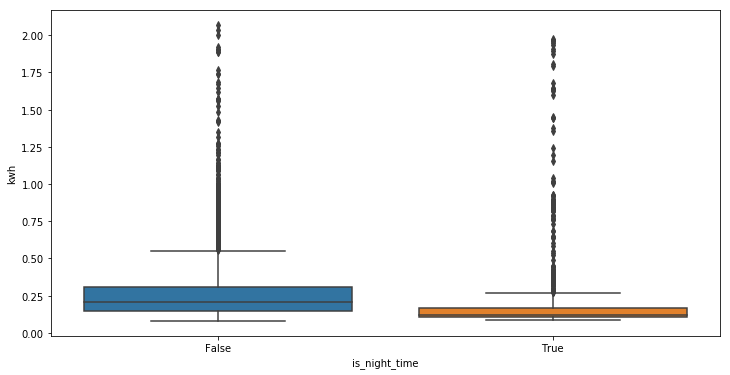

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))
sns.boxplot(x='is_night_time', y='kwh', data=merged_df);

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


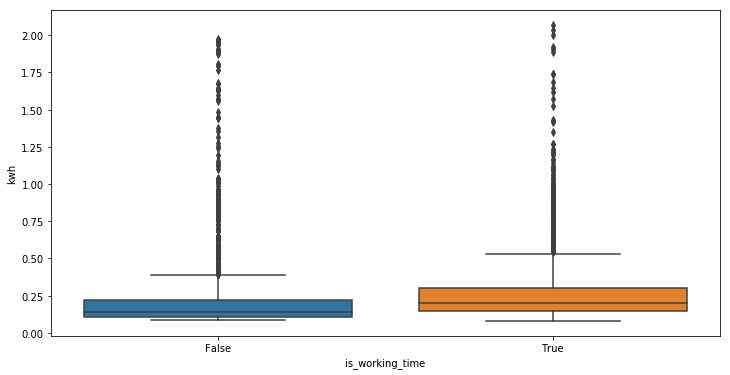

In [38]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_working_time', y='kwh', data=merged_df);

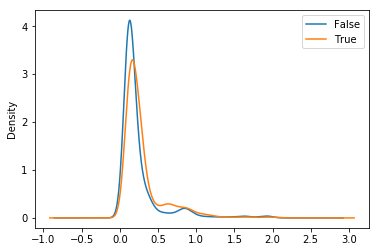

In [39]:
merged_df.groupby('is_working_time').kwh.plot.kde();
plt.legend();

In [40]:
merged_df.groupby('hour').cost.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,121.0,0.059396,0.060232,0.017022,0.026539,0.038619,0.060765,0.328167
1,121.0,0.045049,0.052754,0.017937,0.021231,0.028735,0.040815,0.360197
2,120.0,0.040267,0.053822,0.016655,0.019401,0.023244,0.034089,0.358550
3,121.0,0.035642,0.047330,0.016472,0.018852,0.020865,0.027637,0.358733
4,121.0,0.033958,0.048838,0.016472,0.019035,0.020499,0.024526,0.362027
5,121.0,0.032435,0.046216,0.016472,0.018852,0.019950,0.024343,0.346287
6,121.0,0.032577,0.047754,0.016106,0.018852,0.019584,0.022512,0.331279
7,121.0,0.030566,0.045807,0.016289,0.018669,0.019401,0.022512,0.354523
8,121.0,0.039862,0.053652,0.017754,0.019218,0.024526,0.033128,0.348666


In [41]:
basal_kwh_consum = merged_df.resample('D').kwh.min().quantile(0.5)
basal_kwh_consum

0.1025

In [42]:
merged_df.kwh.min()

0.079

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(0.0, 1.0)

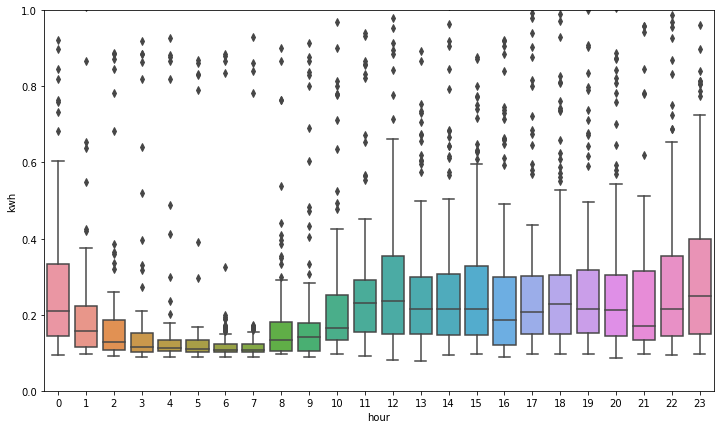

In [43]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='hour', y='kwh', data=merged_df);
plt.ylim(0.0, 1.00)

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


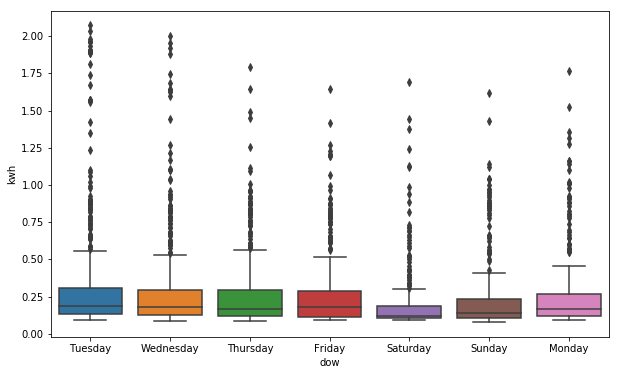

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='dow', y='kwh', data=merged_df);

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


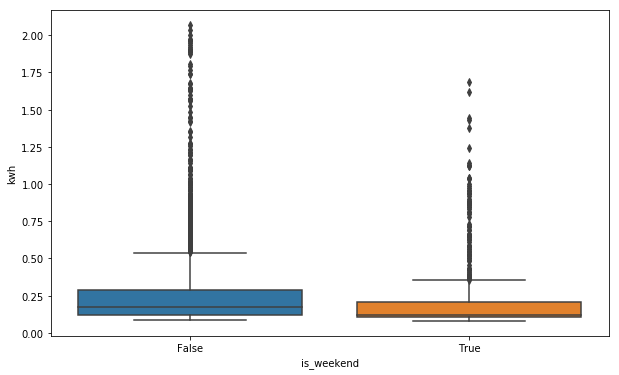

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_weekend', y='kwh', data=merged_df) #, whis="range", palette="vlag");

/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


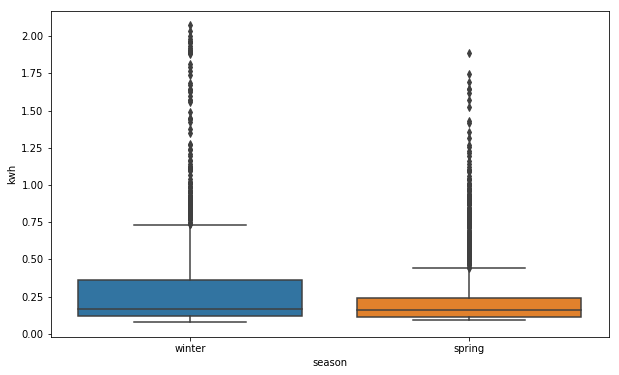

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='kwh', data=df) #, whis="range", palette="vlag");

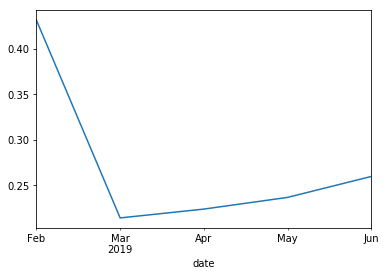

In [47]:
merged_df.resample('M').kwh.mean().plot();

In [48]:
merged_df.resample('M')[['cost', 'discriminative_cost']].mean()

,cost,discriminative_cost
date,,
2019-02-28,0.078951,0.068914
2019-03-31,0.039240,0.036535
2019-04-30,0.041013,0.037743
2019-05-31,0.043361,0.040568
2019-06-30,0.047569,0.045390


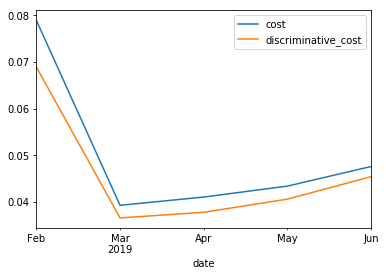

In [49]:
merged_df.resample('M')[['cost', 'discriminative_cost']].mean().plot()
plt.legend();

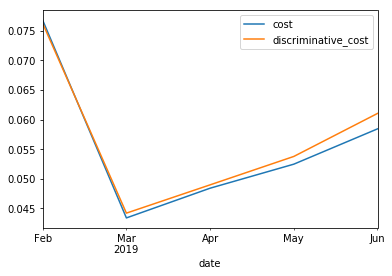

In [50]:
merged_df.loc[merged_df.is_working_time.eq(True)].resample('M')[['cost', 'discriminative_cost']].mean().plot()
plt.legend();

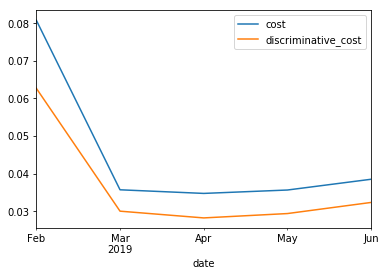

In [51]:
merged_df.loc[merged_df.is_working_time.eq(False)].resample('M')[['cost', 'discriminative_cost']].mean().plot()
plt.legend();

## Daily merged df

In [52]:
daily_merged_df = merged_df.resample('D').mean()
daily_merged_df.head()

,kwh,is_weekend,hour,is_working_time,is_night_time,cost,discriminative_cost,prec,presMax,presMin,racha,sol,tmax,tmed,tmin,velmedia,dir_axis_1,dir_axis_2
date,,,,,,,,,,,,,,,,,,
2019-02-05,1.582870,0.0,12.0,0.478261,0.347826,0.289708,0.248427,0.0,1026.1,1022.8,8.3,10.2,20.3,11.9,3.5,1.9,0.991790,1.278772e-01
2019-02-06,1.044750,0.0,11.5,0.458333,0.375000,0.191217,0.145893,0.0,1023.5,1019.8,6.7,9.8,21.2,13.0,4.9,1.9,0.967295,2.536546e-01
2019-02-07,0.483000,0.0,11.5,0.458333,0.375000,0.088402,0.075275,0.0,1022.0,1018.5,5.0,9.9,21.2,13.0,4.9,1.9,1.000000,-2.449294e-16
2019-02-08,0.489375,0.0,11.5,0.458333,0.375000,0.089569,0.086020,0.1,1021.3,1018.3,4.7,10.1,19.3,12.2,5.1,2.2,1.000000,-2.449294e-16
2019-02-09,0.465583,1.0,11.5,0.458333,0.375000,0.085214,0.074453,NaN,1022.0,1018.8,5.0,9.9,18.1,10.5,2.9,1.7,0.284528,9.586679e-01


/home/infinitemonkeys/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


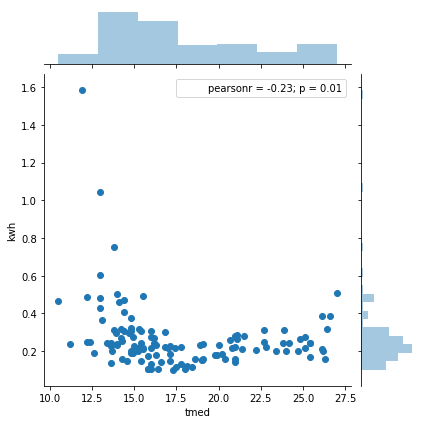

In [53]:
sns.jointplot(x='tmed', y='kwh', data=daily_merged_df)

In [54]:
daily_merged_df.corr().kwh.sort_values(ascending=False)

kwh                    1.000000
cost                   1.000000
discriminative_cost    0.990011
presMin                0.249912
presMax                0.248393
dir_axis_1             0.164895
hour                   0.020456
is_working_time        0.019976
is_night_time         -0.019976
prec                  -0.024607
sol                   -0.042313
velmedia              -0.107124
dir_axis_2            -0.164404
tmax                  -0.174860
racha                 -0.182203
is_weekend            -0.199720
tmed                  -0.232268
tmin                  -0.274036
Name: kwh, dtype: float64

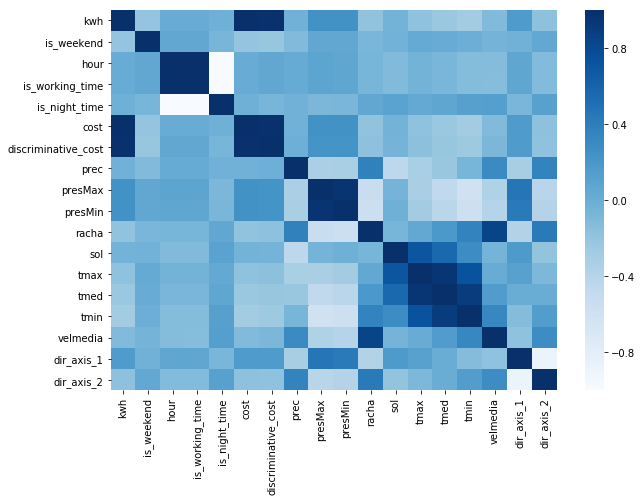

In [55]:
plt.figure(figsize=(10, 7))
sns.heatmap(daily_merged_df.corr(), cmap='Blues');

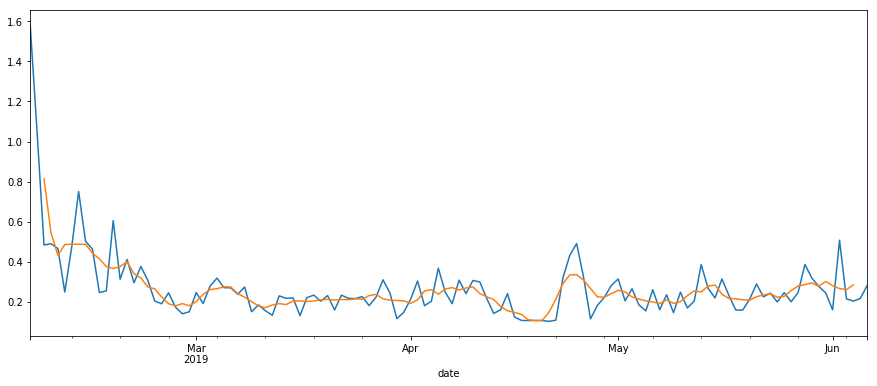

In [56]:
plt.figure(figsize=(15, 6))
daily_merged_df.kwh.plot();
daily_merged_df.kwh.rolling(5, center=True).mean().plot();

In [59]:
merged_df.to_csv('merged_df.csv')